<a href="https://colab.research.google.com/github/fire-long/4J/blob/model2/%EA%B0%90%EA%B7%A4_%EC%B0%A9%EA%B3%BC%EB%9F%89_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 데이콘 5위 코드 배경

- 데이터 탐색 과정에서 새순 feature만 학습해서 제출했는데 정확도가 높아 새순 데이터만 활용(저장양분 축적이 착과량과 밀접한 관계가 있다는 도메인 지식 활용) 


- 자체 테스트 결과 성능이 좋지 않아 별도의 feature engineering 활용 안함(변화량, 차이, pca, data aggregation 등) 


- XGBoost & LightBGM: 짧은 대회 기간 효율, 효과를 고려하여 모델 선택, 모든 새순 feature 활용 


- TabNet: 위 모델 만으로 만족스러운 성능이 나오지 않아 predict value를 가지고 분석, Gradient Boosting Decision Tree Model 특성상 Interpolation predict 경향이 존재하여 TabNet(Neural Network)를 앙상블하여 해당 경향성 완화, 새순 관련 변수 중 착과량에 강한 영향을 미치는 변수만 사용


-> 전반적으로 1. 중요변수확인 > 2. k-fold를 접목한 반복 모델링 > 3. score 측정 과정을 반복하여 모델 생성


# 1. 데이터 불러오기

In [2]:
import pandas as pd

df_train = pd.read_csv("/content/drive/MyDrive/4J DACON/감귤 착과량 예측 AI 경진대회/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/4J DACON/감귤 착과량 예측 AI 경진대회/test.csv")

print(df_train.info())
print(df_train.isnull().sum())

print(df_test.info())
print(df_test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Columns: 184 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), int64(1), object(1)
memory usage: 3.1+ MB
None
ID                0
착과량(int)          0
수고(m)             0
수관폭1(min)         0
수관폭2(max)         0
                 ..
2022-11-24 엽록소    0
2022-11-25 엽록소    0
2022-11-26 엽록소    0
2022-11-27 엽록소    0
2022-11-28 엽록소    0
Length: 184, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Columns: 183 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), object(1)
memory usage: 3.1+ MB
None
ID                0
수고(m)             0
수관폭1(min)         0
수관폭2(max)         0
수관폭평균             0
                 ..
2022-11-24 엽록소    0
2022-11-25 엽록소    0
2022-11-26 엽록소    0
2022-11-27 엽록소    0
2022-11-28 엽록소    0
Length: 183, dtype: int64


In [15]:
labels = df_train["착과량(int)"]
feature_columns = df_train.loc[:, "2022-09-01 새순":"2022-11-28 새순"].columns #새순 열만 불러옴

print("학습에는 새순 Features 89개를 사용했습니다.\n")
print(feature_columns)

학습에는 새순 Features 89개를 사용했습니다.

Index(['2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순',
       '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순', '2022-09-08 새순',
       '2022-09-09 새순', '2022-09-10 새순', '2022-09-11 새순', '2022-09-12 새순',
       '2022-09-13 새순', '2022-09-14 새순', '2022-09-15 새순', '2022-09-16 새순',
       '2022-09-17 새순', '2022-09-18 새순', '2022-09-19 새순', '2022-09-20 새순',
       '2022-09-21 새순', '2022-09-22 새순', '2022-09-23 새순', '2022-09-24 새순',
       '2022-09-25 새순', '2022-09-26 새순', '2022-09-27 새순', '2022-09-28 새순',
       '2022-09-29 새순', '2022-09-30 새순', '2022-10-01 새순', '2022-10-02 새순',
       '2022-10-03 새순', '2022-10-04 새순', '2022-10-05 새순', '2022-10-06 새순',
       '2022-10-07 새순', '2022-10-08 새순', '2022-10-09 새순', '2022-10-10 새순',
       '2022-10-11 새순', '2022-10-12 새순', '2022-10-13 새순', '2022-10-14 새순',
       '2022-10-15 새순', '2022-10-16 새순', '2022-10-17 새순', '2022-10-18 새순',
       '2022-10-19 새순', '2022-10-20 새순', '2022-10-21 새순', '2022-10-22

# 2. 모델링

In [23]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def NMAE(true, pred):
  mae = np.mean(np.abs(true-pred))
  score = mae/np.mean(np.abs(true))
  return score

## 2-1. XGBoost

*참고: https://techblog-history-younghunjo1.tistory.com/142 (oof, k-fold 관련 설명)


https://riverzayden.tistory.com/17(xgboost 관련 설명)

https://romg2.github.io/mlguide/03_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-04.-%EB%B6%84%EB%A5%98-XGBoost/


https://joyfuls.tistory.com/63

In [26]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

x = df_train.loc[:, "2022-09-01 새순":"2022-11-28 새순"]
y = df_train['착과량(int)']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3)

reg = XGBRegressor(objective = "reg:squarederror", n_estimators = 50000, learning_rate = 0.01, subsample = 0.7, colsample_bytree = 0.3, random_state = 42)
reg.fit(x_train, y_train)

XGBRegressor(colsample_bytree=0.3, learning_rate=0.01, n_estimators=50000,
             objective='reg:squarederror', random_state=42, subsample=0.7)

In [24]:
y_pred = reg.predict(x_valid)
y_true = y_valid

print("score: ", NMAE(y_true, y_pred))

score:  0.08224748854658102


### 변수 중요도

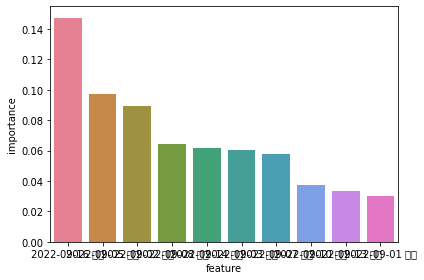

In [48]:
feature_importance_df = pd.DataFrame()
feature_importance_df = pd.concat([feature_importance_df,pd.DataFrame(zip(feature_columns, reg.feature_importances_), columns=["feature", "importance"])])
feature_importance_df = feature_importance_df.groupby("feature").mean().sort_values("importance", ascending=False).reset_index()

import seaborn as sns
more_important = pd.DataFrame(feature_importance_df.head(10))
sns.barplot(data = more_important, x = "feature", y = "importance", palette = "husl")
plt.subplots_adjust(wspace = 2)
plt.tight_layout()
plt.show()

## 4-2. LightGBM

In [49]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(n_estimators = 50000, learning_rate = 0.01, subsample = 0.7, colsample_bytree = 0.3, random_state = 42)
lgb.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=0.3, learning_rate=0.01, n_estimators=50000,
              random_state=42, subsample=0.7)

In [51]:
y_pred = lgb.predict(x_valid)
y_true = y_valid

print("score: ", NMAE(y_true, y_pred))

score:  0.09152027591430514


### 변수 중요도

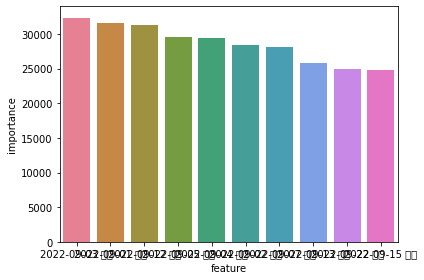

In [52]:
feature_importance_df = pd.DataFrame()
feature_importance_df = pd.concat([feature_importance_df,pd.DataFrame(zip(feature_columns, lgb.feature_importances_), columns=["feature", "importance"])])
feature_importance_df = feature_importance_df.groupby("feature").mean().sort_values("importance", ascending=False).reset_index()

more_important = pd.DataFrame(feature_importance_df.head(10))
sns.barplot(data = more_important, x = "feature", y = "importance", palette = "husl")
plt.subplots_adjust(wspace = 2)
plt.tight_layout()
plt.show()

## 4-3. TabNet

TabNet은 구조화된 테이블 형식 데이터를 위한 해석 가능한 딥 러닝 아키텍처입니다. 이 아키텍처는 단순한 트리 기반 모델의 해석 편의성과 블랙박스 모델 및 앙상블의 높은 정확성이라는 두 가지 장점을 겸비하고 있습니다. 따라서 TabNet은 금융 자산 가격 예측, 사기/사이버 공격/범죄 감지, 소매 수요 예측, 의료 기록에 근거한 진단, 상품 추천과 같은 광범위한 테이블 형식 데이터 작업과 기타 응용 분야에 적합합니다. (https://cloud.google.com/vertex-ai/docs/models/tabnet/overview?hl=ko)

In [64]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.model_selection import KFold
import torch

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
oof_nn = np.zeros(len(df_train))
pred_nn = np.zeros(len(df_test))


feature_columns= ["2022-09-02 새순", "2022-09-07 새순", "2022-09-05 새순", "2022-09-04 새순",
       "2022-09-11 새순", "2022-09-08 새순", "2022-09-16 새순", "2022-09-03 새순",
       "2022-09-10 새순", "2022-09-15 새순", "2022-09-14 새순", "2022-09-01 새순",
       "2022-09-06 새순", "2022-09-09 새순", "2022-09-13 새순", "2022-09-20 새순",
       "2022-09-18 새순", "2022-09-12 새순", "2022-09-17 새순", "2022-09-26 새순",
       "2022-09-19 새순", "2022-09-22 새순", "2022-10-03 새순", "2022-09-24 새순",
       "2022-09-30 새순"] # feature_importance top 31

for trn_idx, val_idx in kfold.split(df_train):
    X_train = df_train.loc[trn_idx, feature_columns].values
    y_train = df_train.loc[trn_idx, "착과량(int)"].values.reshape(-1, 1)
    X_valid = df_train.loc[val_idx, feature_columns].values
    y_valid = df_train.loc[val_idx, "착과량(int)"].values.reshape(-1, 1)

    reg = TabNetRegressor(
        n_d=64, # [8, 64]
        n_a=64, # [8, 64]
        n_steps=10, # [3, 10]
        seed=42,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, # how to use learning rate scheduler
                        "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type="sparsemax" # This will be overwritten if using pretrain model
    )

    reg.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=["train", "valid"],
        loss_fn=torch.nn.L1Loss(),
        eval_metric=["mae"],
        max_epochs=20,
        batch_size=64,
        patience=50,
    )

    oof_nn[val_idx] = reg.predict(X_valid).reshape(-1)
    pred_nn += reg.predict(df_test[feature_columns].values).reshape(-1) / 5

epoch 0  | loss: 369.70227| train_mae: 294.23462| valid_mae: 315.81569|  0:00:02s
epoch 1  | loss: 259.75206| train_mae: 342.34311| valid_mae: 362.19872|  0:00:06s
epoch 2  | loss: 73.17494| train_mae: 295.88639| valid_mae: 304.51641|  0:00:09s
epoch 3  | loss: 51.71096| train_mae: 274.65304| valid_mae: 288.40499|  0:00:12s
epoch 4  | loss: 51.6297 | train_mae: 212.65448| valid_mae: 221.72643|  0:00:15s
epoch 5  | loss: 53.73107| train_mae: 191.84567| valid_mae: 198.54692|  0:00:18s
epoch 6  | loss: 46.61955| train_mae: 143.47753| valid_mae: 149.88402|  0:00:21s
epoch 7  | loss: 46.144  | train_mae: 130.37155| valid_mae: 133.03663|  0:00:24s
epoch 8  | loss: 50.25433| train_mae: 102.81065| valid_mae: 107.1277|  0:00:27s
epoch 9  | loss: 48.36965| train_mae: 76.83462| valid_mae: 76.56702|  0:00:30s
epoch 10 | loss: 46.07758| train_mae: 64.73232| valid_mae: 64.81781|  0:00:33s
epoch 11 | loss: 45.3136 | train_mae: 49.61958| valid_mae: 52.55755|  0:00:36s
epoch 12 | loss: 43.67977| train_

In [68]:
NMAE(labels, oof_nn)

0.09258889778127566